In [1]:
from pathlib import Path
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from scripts.utils import *



In [2]:
DATA_PATH = Path("/workspace/Data/prep_data/prep_v2/")
JSON_PATH = Path("/workspace/Data/raw_data/labeling_json/")

In [4]:
f_list = [f for f in JSON_PATH.iterdir()]

In [9]:
len(f_list)
json_file = f_list[0]

mapper = {}
user_id, channel, _, collected_date, _ = Path(json_file).stem.split("_")
house_id = f"{int(user_id.replace('user','')):03d}"
channel_id = f"ch{channel}"
key = f"H{house_id}_{channel_id}_{collected_date}"
mapper[key] = json_file

In [10]:
key

'H031_ch05_20231110'

In [52]:
data_dict = {
    "user_id": [],
    "channel" : [],
    "mac_add" : [],
    "collected_date" : [],
    "f_path" : [],
    "n_label" : []
}
for f in DATA_PATH.iterdir():
    file_path = str(f)
    user_id, channel, mac_add, collected_date = f.name.split("_")[:4]
    collected_date = collected_date.replace(".parquet", "")
    data_dict['user_id'].append(user_id)
    data_dict['channel'].append(channel)
    data_dict['mac_add'].append(mac_add)
    data_dict['collected_date'].append(collected_date)
    data_dict['f_path'].append(file_path)

    if channel == "01":
        labels = []
    else :
        f_stem = make_file_stem(user_id, channel, mac_add, collected_date)
        json_file = JSON_PATH / f'{f_stem}_original.json'

        with open(json_file,'r') as j:
            data = json.load(j)
        labels = data['labels']
    
    if len(labels) == 0:
        data_dict['n_label'].append(0)
    else :
        data_dict['n_label'].append(len(labels))
        # print(labels, len(labels))

df_all = pd.DataFrame.from_dict(data_dict)


In [53]:
df_all.groupby('channel').count()

,user_id,mac_add,collected_date,f_path,n_label
channel,,,,,
01,2966,2966,2966,2966,2966
02,1320,1320,1320,1320,1320
03,1386,1386,1386,1386,1386
04,1638,1638,1638,1638,1638
05,1743,1743,1743,1743,1743
06,1367,1367,1367,1367,1367
07,1786,1786,1786,1786,1786
08,981,981,981,981,981
09,1780,1780,1780,1780,1780


In [54]:
df_main = df_all.loc[df_all['channel'] == "01"]
df_device = df_all.loc[~(df_all['channel'] == "01")]

#### 라벨이 있는 On state가 있는 데이터만 선택

In [55]:
# df_device_only_labeling = df_device[df_device['n_label'] > 0]
# df_device_only_labeling = df_device_only_labeling.reset_index(drop=True)

# 전체 파일을 선택
df_device_only_labeling = df_device
df_device_only_labeling = df_device_only_labeling.reset_index(drop=True)

In [59]:
print(df_device_only_labeling.shape)

df_device_only_labeling.groupby('channel').count()

(29427, 6)


,user_id,mac_add,collected_date,f_path,n_label
channel,,,,,
02,1320,1320,1320,1320,1320
03,1386,1386,1386,1386,1386
04,1638,1638,1638,1638,1638
05,1743,1743,1743,1743,1743
06,1367,1367,1367,1367,1367
07,1786,1786,1786,1786,1786
08,981,981,981,981,981
09,1780,1780,1780,1780,1780
10,1454,1454,1454,1454,1454


In [60]:
main_path = []
for idx, row in df_device_only_labeling.iterrows():
    user_id = row['user_id']
    collected_date = row['collected_date']

    grab_idx = (df_main['user_id'] == user_id) & (df_main['collected_date'] == collected_date) 

    _path = df_main.loc[grab_idx, 'f_path'].values
    if len(_path) < 1:
        # print(row)
        main_path.append(False)
    else :
        main_path.append(_path[0])

In [61]:
df_device_only_labeling['main_path'] = main_path

df_device_only_labeling

,user_id,channel,mac_add,collected_date,f_path,n_label,main_path
0,user55,07,d4f98d2122fd,20231105,/workspace/Data/prep_data/prep_v2/user55_07_d4...,4,/workspace/Data/prep_data/prep_v2/user55_01_40...
1,user88,19,58cf79f19b2d,20231128,/workspace/Data/prep_data/prep_v2/user88_19_58...,1,/workspace/Data/prep_data/prep_v2/user88_01_40...
2,user50,07,404ccabfe05d,20231026,/workspace/Data/prep_data/prep_v2/user50_07_40...,4,/workspace/Data/prep_data/prep_v2/user50_01_40...
3,user4,21,d4f98d2c4c9d,20231005,/workspace/Data/prep_data/prep_v2/user4_21_d4f...,9,/workspace/Data/prep_data/prep_v2/user4_01_404...
4,user37,17,58cf79f1c389,20231018,/workspace/Data/prep_data/prep_v2/user37_17_58...,5,/workspace/Data/prep_data/prep_v2/user37_01_40...
...,...,...,...,...,...,...,...
29422,user60,07,404ccac2ded1,20231105,/workspace/Data/prep_data/prep_v2/user60_07_40...,4,/workspace/Data/prep_data/prep_v2/user60_01_40...
29423,user76,19,404ccac2df6d,20231117,/workspace/Data/prep_data/prep_v2/user76_19_40...,0,/workspace/Data/prep_data/prep_v2/user76_01_40...
29424,user23,15,404ccabeb719,20231123,/workspace/Data/prep_data/prep_v2/user23_15_40...,2,/workspace/Data/prep_data/prep_v2/user23_01_40...
29425,user50,05,d4f98d1f3959,20231019,/workspace/Data/prep_data/prep_v2/user50_05_d4...,1,/workspace/Data/prep_data/prep_v2/user50_01_40...


## main 없는것 걸러내기

In [62]:
df_device_only_labeling[(df_device_only_labeling['main_path'] == False)].shape

df_device_only_labeling.sort_values(by='n_label',ascending=True)
df_device_only_labeling = df_device_only_labeling[~(df_device_only_labeling['main_path'] == False)]
df_device_only_labeling = df_device_only_labeling.reset_index(drop=True)
df_device_only_labeling.shape

(29160, 7)

In [27]:
df_device_only_labeling = df_device_only_labeling.sort_values(by=['user_id','channel','collected_date'])
df_device_only_labeling = df_device_only_labeling.reset_index(drop=True)
df_device_only_labeling.head()

,user_id,channel,mac_add,collected_date,f_path,n_label,main_path
0,user1,02,404ccabed705,20230924,/workspace/Data/prep_data/prep_v2/user1_02_404...,36,/workspace/Data/prep_data/prep_v2/user1_01_404...
1,user1,02,404ccabed705,20230925,/workspace/Data/prep_data/prep_v2/user1_02_404...,1,/workspace/Data/prep_data/prep_v2/user1_01_404...
2,user1,02,404ccabed705,20230926,/workspace/Data/prep_data/prep_v2/user1_02_404...,2,/workspace/Data/prep_data/prep_v2/user1_01_404...
3,user1,02,404ccabed705,20230928,/workspace/Data/prep_data/prep_v2/user1_02_404...,2,/workspace/Data/prep_data/prep_v2/user1_01_404...
4,user1,02,404ccabed705,20231001,/workspace/Data/prep_data/prep_v2/user1_02_404...,2,/workspace/Data/prep_data/prep_v2/user1_01_404...


In [28]:

temp, test = train_test_split(df_device_only_labeling, test_size=0.2, random_state=42, stratify=df_device_only_labeling['channel'])
X, Val = train_test_split(temp, test_size=0.25, random_state=42, stratify=temp['channel'])

X.shape, Val.shape, test.shape

train_set = X.reset_index(drop=True)
val_set = Val.reset_index(drop=True)
test_set = test.reset_index(drop=True)

In [64]:
test_set = df_device_only_labeling
test_set.to_csv("/workspace/Data/test_set.csv")

In [35]:
train_set
test_set

,user_id,channel,mac_add,collected_date,f_path,n_label,main_path
0,user14,10,404ccac845f9,20231023,/workspace/Data/prep_data/prep_v2/user14_10_40...,2,/workspace/Data/prep_data/prep_v2/user14_01_40...
1,user85,12,404ccac2f3fd,20231118,/workspace/Data/prep_data/prep_v2/user85_12_40...,2,/workspace/Data/prep_data/prep_v2/user85_01_40...
2,user25,15,404ccac2f2f5,20231126,/workspace/Data/prep_data/prep_v2/user25_15_40...,369,/workspace/Data/prep_data/prep_v2/user25_01_40...
3,user55,20,404ccac2d5a5,20231012,/workspace/Data/prep_data/prep_v2/user55_20_40...,1,/workspace/Data/prep_data/prep_v2/user55_01_40...
4,user11,03,404ccac62fc5,20231009,/workspace/Data/prep_data/prep_v2/user11_03_40...,4,/workspace/Data/prep_data/prep_v2/user11_01_40...
...,...,...,...,...,...,...,...
3908,user54,18,404ccabfff05,20231103,/workspace/Data/prep_data/prep_v2/user54_18_40...,1,/workspace/Data/prep_data/prep_v2/user54_01_40...
3909,user7,07,404ccac08079,20231011,/workspace/Data/prep_data/prep_v2/user7_07_404...,1,/workspace/Data/prep_data/prep_v2/user7_01_404...
3910,user1,02,404ccabed705,20231021,/workspace/Data/prep_data/prep_v2/user1_02_404...,1,/workspace/Data/prep_data/prep_v2/user1_01_404...
3911,user95,20,d4f98d2c3a59,20231118,/workspace/Data/prep_data/prep_v2/user95_20_d4...,1,/workspace/Data/prep_data/prep_v2/user95_01_40...


In [36]:
train_set.to_csv("/workspace/Data/train_set.csv")
val_set.to_csv("/workspace/Data/val_set.csv")
test_set.to_csv("/workspace/Data/test_set.csv")

# Making stats

In [2]:
stats = []
for f in Path("/workspace/Data/statistics/stats_v2").iterdir():
    channel = f.name.split("_")[1]
    _df = pd.read_csv(f, names=['max_val', 'min_val', 'mean_val', 'std_dev', 'active_interval_mean', 'active_interval_max', 'active_interval_min', 'active_interval_std'])
    _df['channel'] = channel
    _df['f_name'] = f.name

    stats.append(_df)

In [3]:
stats_merge = pd.concat(stats)
stats_merge.head()
# stats_merge[stats_merge['channel'] == "01"]

,max_val,min_val,mean_val,std_dev,active_interval_mean,active_interval_max,active_interval_min,active_interval_std,channel,f_name
0,3.19,0.25,1.171206,0.152469,NaN,NaN,NaN,NaN,17,user52_17_d4f98d1f5dc9_20231018_stat.csv
0,0.78,0.33,0.554632,0.039992,NaN,NaN,NaN,NaN,03,user41_03_404ccac851f5_20231019_stat.csv
0,2686.65,216.45,332.850562,196.943830,NaN,NaN,NaN,NaN,01,user6_01_404ccac56425_20231013_stat.csv
0,3234.81,0.85,32.264880,251.724949,1655.996965,3234.81,1.17,723.154229,16,user70_16_404ccac30ca1_20231125_stat.csv
0,1.90,0.15,0.612266,0.121278,NaN,NaN,NaN,NaN,02,user65_02_404ccac2aa81_20231021_stat.csv


In [7]:
stats_merge.columns

Index(['max_val', 'min_val', 'mean_val', 'std_dev', 'active_interval_mean',
       'active_interval_max', 'active_interval_min', 'active_interval_std',
       'channel', 'f_name'],
      dtype='object')

In [10]:
stats_merge.groupby('channel')[['max_val', 'min_val', 'mean_val', 'std_dev', 'active_interval_mean',
       'active_interval_max', 'active_interval_min', 'active_interval_std',]].mean().to_csv("/workspace/Data/statistics_231214.csv")
stats_merge.groupby('channel')[['max_val', 'min_val', 'mean_val', 'std_dev', 'active_interval_mean',
       'active_interval_max', 'active_interval_min', 'active_interval_std',]].mean()

,max_val,min_val,mean_val,std_dev,active_interval_mean,active_interval_max,active_interval_min,active_interval_std
channel,,,,,,,,
01,3512.807714,145.363500,413.822673,309.414933,NaN,NaN,NaN,NaN
02,144.466515,0.360848,24.104099,36.307502,102.242812,156.857233,0.892717,15.817936
03,34.025036,0.255830,2.033558,4.446281,32.948572,55.167633,0.517929,6.166461
04,1032.959731,0.088767,5.508796,64.520093,1356.464827,1434.876058,0.664826,117.013114
05,611.209443,1.350620,18.901846,60.320564,138.279412,847.612137,1.732049,189.145828
06,705.525662,0.435611,10.667002,57.911116,211.812996,1244.581231,1.148782,314.929120
07,1100.979507,0.025789,3.323619,50.180623,1040.038068,1390.266762,1.209564,263.369131
08,986.775556,0.237258,3.507024,34.839896,758.953318,1609.499712,1.315871,83.555129
09,932.529056,0.430713,4.071840,49.931834,880.221317,1197.890435,1.536720,333.119727


In [18]:
# stats_merge.groupby('channel')[['active_interval_mean',	'active_interval_max',	'active_interval_min',	'active_interval_std'	]].mean().reset_index().to_csv('/workspace/device_active_power_stats.csv')
stats_merge[['max_val', 'min_val', 'mean_val', 'std_dev', 'active_interval_mean',
       'active_interval_max', 'active_interval_min', 'active_interval_std','channel']].groupby('channel').mean().reset_index().to_csv('/workspace/device_active_power_stats.csv')
stats_merge[['max_val', 'min_val', 'mean_val', 'std_dev', 'active_interval_mean',
       'active_interval_max', 'active_interval_min', 'active_interval_std','channel']].groupby('channel').mean().reset_index()#.to_csv('/workspace/device_active_power_stats.csv')

,channel,max_val,min_val,mean_val,std_dev,active_interval_mean,active_interval_max,active_interval_min,active_interval_std
0,01,3506.031469,150.698118,417.377311,302.941371,NaN,NaN,NaN,NaN
1,02,148.485284,0.382619,24.033463,36.177113,104.116742,163.125513,0.586564,16.442904
2,03,32.852359,0.265165,2.148842,4.561081,32.373763,52.389513,0.529858,4.987393
3,04,900.794037,0.066667,4.785411,53.568311,1365.593459,1431.761403,0.916997,102.038468
4,05,576.536107,1.248333,17.098559,57.102762,142.123618,884.343897,1.954086,198.903229
5,06,727.713154,0.453579,10.689780,58.835684,215.960303,1262.683231,0.980325,318.462030
6,07,1008.487143,0.029728,2.859804,43.986876,1046.529334,1368.406102,2.454685,247.103080
7,08,653.100368,0.230920,2.515843,21.207830,777.873496,1631.204105,0.821737,90.658882
8,09,845.202677,0.395707,3.187386,40.788933,1020.105030,1201.477101,1.761874,273.731890
9,10,829.281273,0.028904,7.104264,62.694179,881.644991,1735.542925,0.446763,575.655129


In [40]:
target_files = df_device_only_labeling['f_path'].apply(lambda x: Path(x).stem+'_stat.csv').to_list()
_temp = df_device_only_labeling['main_path'].apply(lambda x: Path(x).stem)+'_stat.csv'
target_files = target_files + _temp.to_list()
stats_selected = stats_merge[stats_merge['f_name'].isin(target_files)].groupby('channel')[['mean_val','std_dev','max_val','min_val']].mean()


In [43]:
stats_selected

,mean_val,std_dev,max_val,min_val
channel,,,,
01,418.891672,305.307337,3514.751215,149.916592
02,26.341587,39.948310,163.721414,0.269126
03,3.241771,7.358355,52.496656,0.287350
04,7.513485,85.306436,1431.117715,0.027351
05,25.473057,87.646698,883.224236,1.314688
06,17.992318,102.187055,1258.738657,0.446298
07,3.908569,60.551659,1369.058624,0.033508
08,5.973647,54.296750,1658.716053,0.337158
09,4.271864,58.577423,1203.017997,0.364713


In [44]:
stats_selected.to_csv("/workspace/Data/statistics_231205_MAE.csv")

In [44]:
int(40641 * 0.8), int((40641)*0.1), int(40641*0.1), int(40641 * 0.8) + int(40641*0.2*0.1) + int(40641*0.2*0.1)

(32512, 4064, 4064, 34136)

In [45]:
32512 + 4064 +4064

40640

In [29]:
import numpy as np
import pandas as pd
from pathlib import Path
import fastparquet


df_train = pd.read_csv('/workspace/Data/train_set.csv', index_col=0)
df_val = pd.read_csv('/workspace/Data/val_set.csv', index_col=0)

In [48]:
len(df_train['f_path'].unique())

19562

In [27]:
# Create a dictionary to map file paths to channels
file_channel_map = dict(zip(df_train['f_path'], df_train['channel']))

# Function to process each file
def process_file(file_path):
    _path = Path(file_path).stem
    parquet_path = f'/workspace/Data/downsampling_data/down_6S/{_path}_donwsampling.parquet'
    fdf = fastparquet.ParquetFile(parquet_path)
    total_len = sum(len(_df) for _df in fdf.iter_row_groups(columns=['active_power', 'label']) if _df['label'].sum() >= 1)
    return file_channel_map[file_path], total_len

# Process files and accumulate counts
counter = {'training': {}, 'validation': []}
for file_path in df_train['f_path'].unique():  # Limit to the first 100 unique file paths
    channel, length = process_file(file_path)
    counter['training'][channel] = counter['training'].get(channel, 0) + length

In [36]:
# Create a dictionary to map file paths to channels
file_channel_map = dict(zip(df_val['f_path'], df_val['channel']))

# Function to process each file
def process_file(file_path):
    _path = Path(file_path).stem
    parquet_path = f'/workspace/Data/downsampling_data/down_6S/{_path}_donwsampling.parquet'
    fdf = fastparquet.ParquetFile(parquet_path)
    total_len = sum(len(_df) for _df in fdf.iter_row_groups(columns=['active_power', 'label']) if _df['label'].sum() >= 1)
    return file_channel_map[file_path], total_len

# Process files and accumulate counts
for file_path in df_val['f_path'].unique():  # Limit to the first 100 unique file paths
    channel, length = process_file(file_path)
    counter['validation'][channel] = counter['validation'].get(channel, 0) + length

In [43]:
crop = [21,22,23]

for stats, item in counter.items():
    for c, v in item.items():
        if c in crop:
            print(stats, c, v, v // 4)
            counter[stats][c] = v // 4

training 21 23499000 5874750
training 23 2792400 698100
training 22 15727800 3931950
validation 21 4689600 1172400
validation 22 3147900 786975
validation 23 633300 158325


In [45]:
counter

{'training': {2: 5486700,
  3: 1719900,
  4: 1143600,
  5: 9008100,
  6: 1213500,
  7: 862200,
  9: 1056300,
  10: 483900,
  17: 4236300,
  20: 2510700,
  21: 5874750,
  23: 698100,
  11: 912600,
  18: 990900,
  19: 9573600,
  8: 593400,
  14: 3756000,
  22: 3931950,
  13: 1281300,
  16: 980400,
  12: 351600,
  15: 2258400},
 'validation': {2: 1164300,
  15: 459300,
  3: 374100,
  19: 1918200,
  16: 201900,
  7: 169200,
  5: 1791900,
  20: 547200,
  21: 1172400,
  9: 208200,
  8: 87300,
  18: 210900,
  10: 103200,
  17: 759000,
  13: 262200,
  14: 765300,
  6: 235200,
  4: 256200,
  11: 184500,
  22: 786975,
  23: 158325,
  12: 72000}}

In [118]:
_df = pd.read_csv("/workspace/Data/dataset-1120.csv")
_df
arr =  _df.loc[:,['data_path', 'main_path']].values
# arrrr.shape
rng = np.random.RandomState(seed=42)
arr_sh = np.random.permutation(arr)

In [130]:

arr[:int(arr.shape[0]/10),1].shape

(462,)

In [15]:
import numpy as np
import json
import matplotlib.pyplot as plt

with open("./workspace/ckp/02/state-02.json", 'r') as j:
    data = json.load(j)

In [19]:
data.keys()

dict_keys(['batch_count', 'epoch', 'channel', 'train_best_mse_loss', 'train_best_mae_loss', 'val_best_mae_loss', 'train_mse_losses', 'train_mae_losses', 'val_mae_lossed', 'last_ckp'])

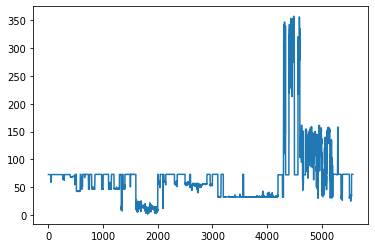

In [20]:
plt.plot(data['val_mae_lossed'])

In [71]:
import gzip
rawfile = Path('/workspace/Data/device_active_power_data') / f"user4_07_404ccac0e859_20231006_original.csv.gz"
data = []
with gzip.open(rawfile, 'rt') as gz_file:
    header = gz_file.readline()  # Assuming first line is header
    for line in gz_file:
        split_line = line.strip().split(',')
        data.append(split_line)

data_df = pd.DataFrame(data, columns=['time_stamps', 'active_power'])
data_df['active_power'] = pd.to_numeric(data_df['active_power'], errors='coerce')

In [72]:
import numpy as np

data_df.loc[data_df['active_power'] < 0,'active_power'] = np.NAN


In [89]:
data_df['active_power_inter']=data_df['active_power'].interpolate(method='spline', order=2)
data_df.iloc[706048-5:706048+55]


,time_stamps,active_power,active_power_inter
706043,2023-10-06 06:32:14.767,982.57,982.570000
706044,2023-10-06 06:32:14.800,797.23,797.230000
706045,2023-10-06 06:32:14.833,536.43,536.430000
706046,2023-10-06 06:32:14.867,275.63,275.630000
706047,2023-10-06 06:32:14.900,14.83,14.830000
706048,2023-10-06 06:32:14.933,NaN,-329.113579
706049,2023-10-06 06:32:14.967,NaN,-663.120515
706050,2023-10-06 06:32:15.000,NaN,-993.372286
706051,2023-10-06 06:32:15.033,NaN,-1319.868892
706052,2023-10-06 06:32:15.067,NaN,-1642.610332


In [19]:
test_dataset = test_dataset[~(test_dataset['main_path'] == False)]
test_dataset = test_dataset.reset_index(drop=True)
test_dataset.to_csv('./test_dataset.csv', index=False)

In [7]:
_df = pd.read_csv('./test_dataset.csv')
parquet_list = _df.loc[:,['data_path', 'main_path']].values

In [8]:
device_parquet = list(parquet_list[:,0])
list_part_parquet = device_parquet[0:5]
list_part_parquet

['/workspace/external/ssd/gray/Datalake/insNILM/training_data/parquet/user1_02_404ccabed705_20231015.parquet',
 '/workspace/external/ssd/gray/Datalake/insNILM/training_data/parquet/user3_02_404ccabeb24d_20231006.parquet',
 '/workspace/external/ssd/gray/Datalake/insNILM/training_data/parquet/user1_02_404ccabed705_20231004.parquet',
 '/workspace/external/ssd/gray/Datalake/insNILM/training_data/parquet/user2_02_404ccaba891d_20231013.parquet',
 '/workspace/external/ssd/gray/Datalake/insNILM/training_data/parquet/user3_02_404ccabeb24d_20231003.parquet']

In [9]:
fparquet = fastparquet.ParquetFile(list_part_parquet)
_data = []
for df in fparquet.iter_row_groups(columns=['active_power']):
    _data.append(df)
    

In [10]:
df = pd.concat(_data)

In [11]:
test_dataset.head()

,user_id,channel,mac_add,collected_date,data_path,main_path
0,user1,02,404ccabed705,20231015,/workspace/external/ssd/gray/Datalake/insNILM/...,/workspace/external/ssd/gray/Datalake/insNILM/...
1,user3,02,404ccabeb24d,20231006,/workspace/external/ssd/gray/Datalake/insNILM/...,/workspace/external/ssd/gray/Datalake/insNILM/...
2,user1,02,404ccabed705,20231004,/workspace/external/ssd/gray/Datalake/insNILM/...,/workspace/external/ssd/gray/Datalake/insNILM/...
3,user2,02,404ccaba891d,20231013,/workspace/external/ssd/gray/Datalake/insNILM/...,/workspace/external/ssd/gray/Datalake/insNILM/...
4,user3,02,404ccabeb24d,20231003,/workspace/external/ssd/gray/Datalake/insNILM/...,/workspace/external/ssd/gray/Datalake/insNILM/...


In [12]:
test_dataset.iloc[0:3, 4:6].values[:,0]
test_dataset.iloc[0:3, 4:6].values[:,1]

array(['/workspace/external/ssd/gray/Datalake/insNILM/training_data/parquet/user1_01_404ccac2f0c9_20231015.parquet',
       '/workspace/external/ssd/gray/Datalake/insNILM/training_data/parquet/user3_01_404ccac31555_20231006.parquet',
       '/workspace/external/ssd/gray/Datalake/insNILM/training_data/parquet/user1_01_404ccac2f0c9_20231004.parquet'],
      dtype=object)

In [13]:
import fastparquet

device_parquet = test_dataset.iloc[0:3, 4:6].values[:,0].tolist()
main_parquet = test_dataset.iloc[0:3, 4:6].values[:,1].tolist()

fdf_device = fastparquet.ParquetFile(device_parquet)
fdf_main = fastparquet.ParquetFile(main_parquet)

In [12]:
device_parquet

['/workspace/external/ssd/gray/Datalake/insNILM/training_data/parquet/user1_02_404ccabed705_20231015.parquet',
 '/workspace/external/ssd/gray/Datalake/insNILM/training_data/parquet/user3_02_404ccabeb24d_20231006.parquet',
 '/workspace/external/ssd/gray/Datalake/insNILM/training_data/parquet/user1_02_404ccabed705_20231004.parquet']

In [14]:
list_df = []
for _df in zip(fdf_device.iter_row_groups(columns=['active_power']), fdf_main.iter_row_groups(columns=['active_power'])):
    _device = _df[0]
    _device['main_power'] = _df[1]['active_power']
    list_df.append(_device)

In [27]:
len(_device.iloc[:21600])

21600

In [14]:
_df = pd.concat(list_df)

In [24]:
_df.iloc[0:9000]['main_power'].to_numpy().reshape(-1, 1)[0]

array([498.09])

In [157]:
batch_size = 1024
cached_sequence_length = 18000
_df.shape[0] / batch_size

7593.75

In [6]:
import numpy as np

a = [1,2,3,4]

np.mean(a)

1001 % 100

1

In [24]:
(46440 * 0.16) / 60 / 60 , 21600 - 21600 // (2 * 4), 21600 // (4 * 8)

(2.064, 18900, 675)

In [61]:
(87075 * 0.788) / 60 / 60

19.05975